In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [41]:
#reading the data generate d
personal_df = pd.read_csv("/kaggle/input/personaldataset/personal_data.csv")
common_pins_4 = ["1234", "1111", "0000", "1212", "7777", "1004", "2000", "4444", "2222", "6969",
    "9999", "3333", "5555", "6666", "1122", "1313", "8888", "4321", "2001", "1010",
    "2580", "9990", "1230", "1984", "1987", "1211", "1110", "1100", "2112", "1000",
    "1980", "1919", "1231", "1515", "1011", "1213", "1590", "1233", "1985", "5050",
    "1221", "1414", "1990", "2002", "1991", "1510", "1020", "1988", "6543", "2100",
    "1225", "4440", "3330", "2004", "1232", "1235", "7890", "2003", "2323", "6660",
    "0909", "1999", "1911", "9110", "0101", "1210", "2121", "1121", "1112", "7070",
    "1986", "1239", "1470", "1119", "1120", "0001", "1101", "1011", "1992", "1012",
    "1236", "1983", "1015", "1471", "1357", "1511", "1130", "1123", "0100", "1237",
    "1214", "1993", "9998", "1238", "1230", "5051", "4320", "0111", "1001", "6960"]
common_pins_6 = [
    "123456", "111111", "000000", "121212", "654321", "666666", "112233", "789456", "123123", "159753",
    "321321", "456456", "121314", "147258", "123321", "111222", "111112", "123654", "000123", "321654",
    "111000", "777777", "999999", "222222", "333333", "444444", "555555", "888888", "101010", "123789",
    "987654", "159159", "321123", "121121", "111999", "110110", "112112", "113113", "989898", "121314",
    "999000", "000999", "000001", "111123", "987987", "112211", "445566", "123006", "123111", "998877",
    "223344", "007007", "147147", "741852", "258456", "369258", "101101", "010101", "121416", "314159",
    "314314", "121111", "120120", "130130", "140140", "150150", "160160", "112358", "789123", "666999",
    "444555", "333444", "123098", "456123", "654987", "741963", "369147", "456654", "321987", "010203",
    "987321", "101112", "987123", "102938", "555000", "110101", "232323", "565656", "212121", "888999",
    "101202", "787878", "112211", "554433", "332211", "998899", "900900", "135790", "246810", "109876"
]
#common pins from http://www.datagenetics.com/blog/september32012/

In [42]:
#uderstanding the dataset , 
personal_df.head()


,pin,dob,spouse_dob,anniversary,child_dob,pet_dob
0,271269,27-12-1969,30-03-1962,03-09-2004,26-12-2010,03-01-2010
1,1067,19-10-1967,07-11-1997,07-11-1982,03-05-2001,07-02-2007
2,2654,19-05-1962,02-11-1977,20-08-2017,20-11-2009,28-01-2015
3,6789,12-12-1973,26-04-1979,13-03-2010,01-08-2004,30-01-2007
4,1109,09-11-1990,24-09-1983,24-11-1983,10-08-2020,10-01-2017


In [43]:
#data preprocessing and feature extraction
dates =  ["dob", "spouse_dob", "anniversary", "child_dob", "pet_dob"]
personal_df[dates] = personal_df[dates].apply(pd.to_datetime,format="%d-%m-%Y")
personal_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   pin          1000 non-null   int64         
 1   dob          1000 non-null   datetime64[ns]
 2   spouse_dob   1000 non-null   datetime64[ns]
 3   anniversary  1000 non-null   datetime64[ns]
 4   child_dob    1000 non-null   datetime64[ns]
 5   pet_dob      1000 non-null   datetime64[ns]
dtypes: datetime64[ns](5), int64(1)
memory usage: 47.0 KB


In [44]:
#extraction of more features 
personal_df["digits"] = personal_df["pin"].apply(lambda x: list(map(int, str(x))))
personal_df["length"] = personal_df["digits"].apply(len) #length also determines strength
personal_df["variance"] = personal_df["digits"].apply(np.var) #variation
personal_df["repeat"] = personal_df["digits"].apply(lambda digits: max(digits.count(d) for d in digits)) #repetition of pin digitss
personal_df.drop(columns=["digits"], inplace=True)
personal_df.head()

,pin,dob,spouse_dob,anniversary,child_dob,pet_dob,length,variance,repeat
0,271269,1969-12-27,1962-03-30,2004-09-03,2010-12-26,2010-01-03,6,8.916667,2
1,1067,1967-10-19,1997-11-07,1982-11-07,2001-05-03,2007-02-07,4,9.250000,1
2,2654,1962-05-19,1977-11-02,2017-08-20,2009-11-20,2015-01-28,4,2.187500,1
3,6789,1973-12-12,1979-04-26,2010-03-13,2004-08-01,2007-01-30,4,1.250000,1
4,1109,1990-11-09,1983-09-24,1983-11-24,2020-08-10,2017-01-10,4,13.187500,2


In [45]:
#rule based scoring function
def score_mpin(pin, user_dob, spouse_dob, anniversary, child_dob, pet_dob):
    reasons = []
    score = 0
    pin = str(pin)
    if pin in common_pins_4 or pin in common_pins_6:
        score += 2
        reasons.append("COMMONLY_USED")

    #matching dates
    def matches(pin, dt):
        if pd.isnull(dt):
            return False
        patterns = [
            dt.strftime("%d%m"),       
            dt.strftime("%m%d"),       
            dt.strftime("%y%m"),       
            dt.strftime("%m%y"),      
            dt.strftime("%y%d"),       
            dt.strftime("%d%y"),      
            dt.strftime("%Y"),        
            dt.strftime("%d%m%y"),     
            dt.strftime("%m%d%y"),     
            dt.strftime("%y%m%d"),     
            dt.strftime("%Y%m"),       
            dt.strftime("%Y%d")        
        ]
        return pin in patterns

    #requirement checks
    for label, date in [
        ("DOB", user_dob),
        ("SPOUSE", spouse_dob),
        ("ANNIVERSARY", anniversary),
        ("CHILD", child_dob),
        ("PET", pet_dob)
    ]:
        if matches(pin, date):
            score += 5 if label in ["CHILD", "PET"] else 6
            reasons.append(f"DEMOGRAPHIC_{label}")

    #variance(variaton of digit spreadd) , repetition-how much digits are repeated
    digits = list(map(int, pin))
    variance = np.var(digits)
    repeat = max(digits.count(d) for d in digits)
    unique = len(set(digits))

#scoring logic
    
    if variance < 1.0:
        score += 1
        reasons.append("LOW_VARIANCE")
    if repeat >= 3:
        score += 1
        reasons.append("REPEATED_DIGITS")
    if unique <= 2:
        score += 1
        reasons.append("LOW_UNIQUENESS")
    
    if score <= 2:
        strength = "STRONG"
    elif score <= 5:
        strength = "MODERATE"
    else:
        strength = "WEAK"

    return score, strength, reasons
personal_df[["score", "strength", "reasons"]] = personal_df.apply(
    lambda row: pd.Series(score_mpin(
        row["pin"],
        row["dob"],
        row["spouse_dob"],
        row["anniversary"],
        row["child_dob"],
        row["pet_dob"]
    )), axis=1
)

In [46]:
reason_exploded = personal_df.explode("reasons")
reason_exploded = reason_exploded.dropna(subset=["reasons"])
reason_counts = reason_exploded["reasons"].value_counts()



In [47]:
personal_df.head()

,pin,dob,spouse_dob,anniversary,child_dob,pet_dob,length,variance,repeat,score,strength,reasons
0,271269,1969-12-27,1962-03-30,2004-09-03,2010-12-26,2010-01-03,6,8.916667,2,6,WEAK,[DEMOGRAPHIC_DOB]
1,1067,1967-10-19,1997-11-07,1982-11-07,2001-05-03,2007-02-07,4,9.250000,1,6,WEAK,[DEMOGRAPHIC_DOB]
2,2654,1962-05-19,1977-11-02,2017-08-20,2009-11-20,2015-01-28,4,2.187500,1,0,STRONG,[]
3,6789,1973-12-12,1979-04-26,2010-03-13,2004-08-01,2007-01-30,4,1.250000,1,0,STRONG,[]
4,1109,1990-11-09,1983-09-24,1983-11-24,2020-08-10,2017-01-10,4,13.187500,2,6,WEAK,[DEMOGRAPHIC_DOB]


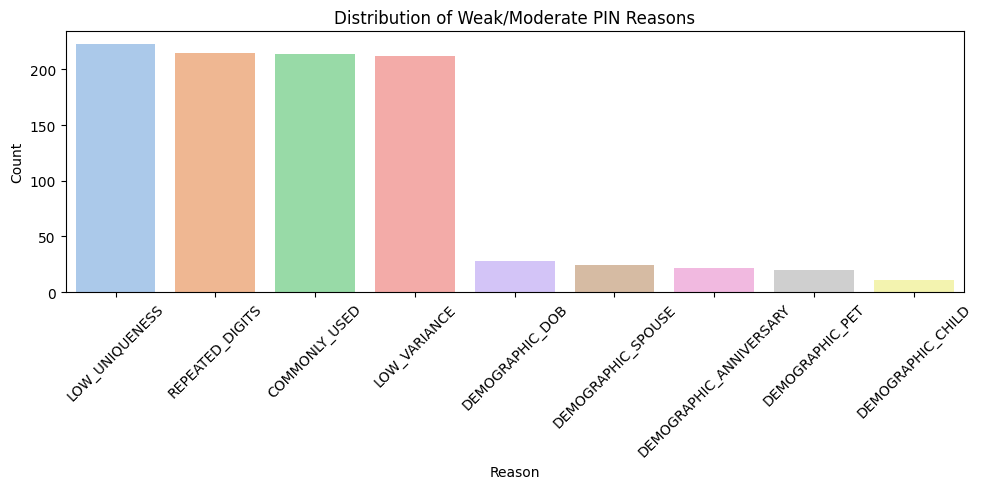

In [48]:
#distribution of reasons
plt.figure(figsize=(10, 5))
sns.barplot(x=reason_counts.index, y=reason_counts.values, palette="pastel")
plt.title("Distribution of Weak/Moderate PIN Reasons")
plt.xlabel("Reason")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

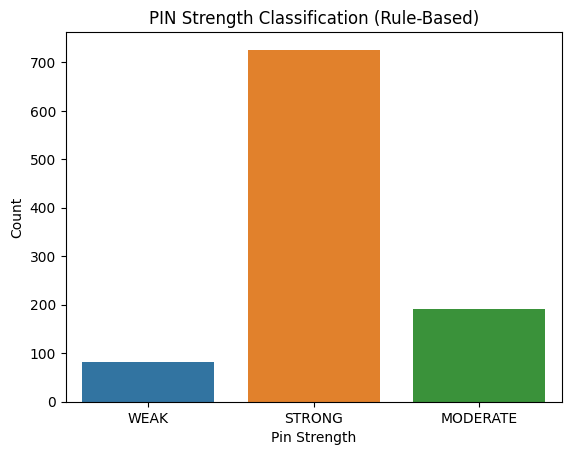

In [49]:
# Strength distribution
sns.countplot(x="strength", data=personal_df)
plt.title("PIN Strength Classification (Rule-Based)")
plt.xlabel("Pin Strength")
plt.ylabel("Count")
plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


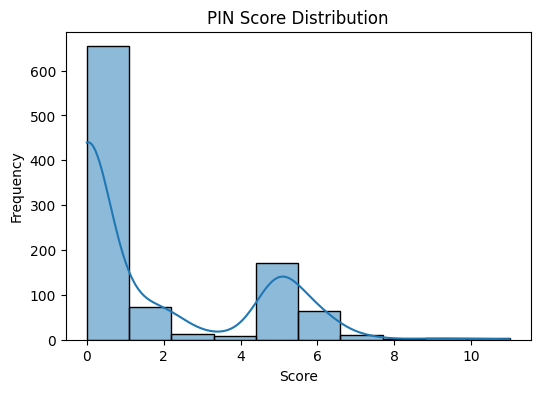

In [50]:
# Score histogram
plt.figure(figsize=(6, 4))
sns.histplot(personal_df["score"], bins=10, kde=True)
plt.title("PIN Score Distribution")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.show()

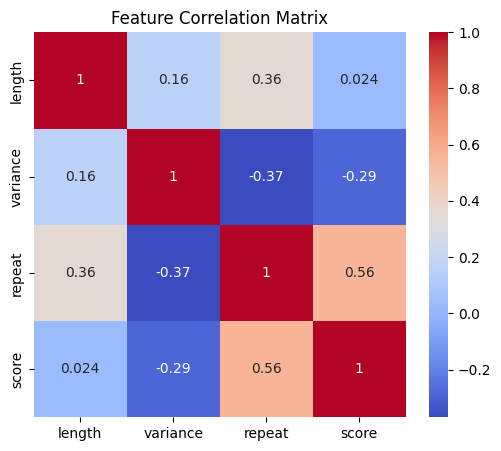

In [51]:
# Correlation heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(personal_df[["length", "variance", "repeat", "score"]].corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()

In [52]:
output_file = "mpin_strength_labeled.csv"
personal_df.to_csv(output_file, index=False)
print(f"Scored data saved successfully to '{output_file}'")

Scored data saved successfully to 'mpin_strength_labeled.csv'
